<a href="https://colab.research.google.com/github/froestiago/pytorch-course/blob/main/04_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. Pytorch Custom Datasets

## 0. Importing Pytorch and setting up device-agnostic code

In [37]:
import torch
from torch import nn

In [38]:
# Setup device-agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Get data!

we'll use a subset (3 classes, 0.1 data) of the Food101 dataset

In [39]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
  print(f'{image_path} directory already exists... skipping download')
else:
  print(f'{image_path} does not exist, creating it...')
  image_path.mkdir(parents = True,
                   exist_ok = True)

  # download data
  with open(data_path/'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print(f'downloading data')
    f.write(request.content)

  # unzip data
  with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('unziping data')
    zip_ref.extractall(image_path)



data/pizza_steak_sushi directory already exists... skipping download


## 2. one with the data
data preparation and exploration

In [40]:
import os

def walk_through_dir(dir_path):
  """
    walks through dir_path returning its contents.
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'there are {len(dirnames)} directories and {len(filenames)} images in `{dirpath}`.')

In [41]:
walk_through_dir(image_path)

there are 2 directories and 0 images in `data/pizza_steak_sushi`.
there are 3 directories and 0 images in `data/pizza_steak_sushi/train`.
there are 0 directories and 75 images in `data/pizza_steak_sushi/train/steak`.
there are 0 directories and 78 images in `data/pizza_steak_sushi/train/pizza`.
there are 0 directories and 72 images in `data/pizza_steak_sushi/train/sushi`.
there are 3 directories and 0 images in `data/pizza_steak_sushi/test`.
there are 0 directories and 19 images in `data/pizza_steak_sushi/test/steak`.
there are 0 directories and 25 images in `data/pizza_steak_sushi/test/pizza`.
there are 0 directories and 31 images in `data/pizza_steak_sushi/test/sushi`.


In [42]:
# setup train and testing paths

train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

data/pizza_steak_sushi/train/steak/2979061.jpg
steak
random image path: data/pizza_steak_sushi/train/steak/2979061.jpg
image class: steak
image height: 512
image width: 512


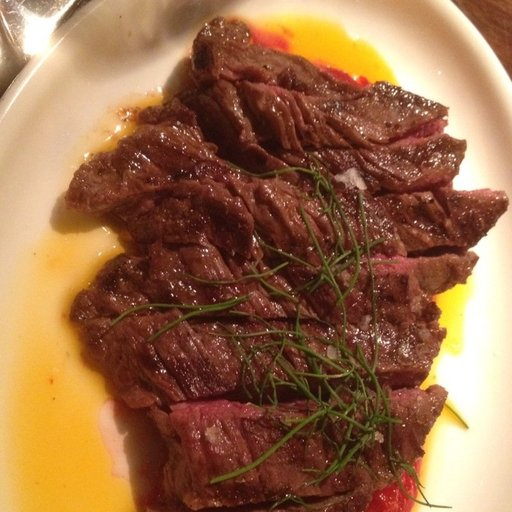

In [43]:
import random
from PIL import Image

# set seed
random.seed(42)

# 1. get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. pick a random image path
random_image_path = random.choice(image_path_list)
print(f'{random_image_path}')

# 3. Get image class from path name (dir name)
image_class = random_image_path.parent.stem
print(f'{image_class}')

# 4. open image
img = Image.open(random_image_path)

# 5. print metadata
print(f'random image path: {random_image_path}')
print(f'image class: {image_class}')
print(f'image height: {img.height}')
print(f'image width: {img.width}')
img

(-0.5, 511.5, 511.5, -0.5)

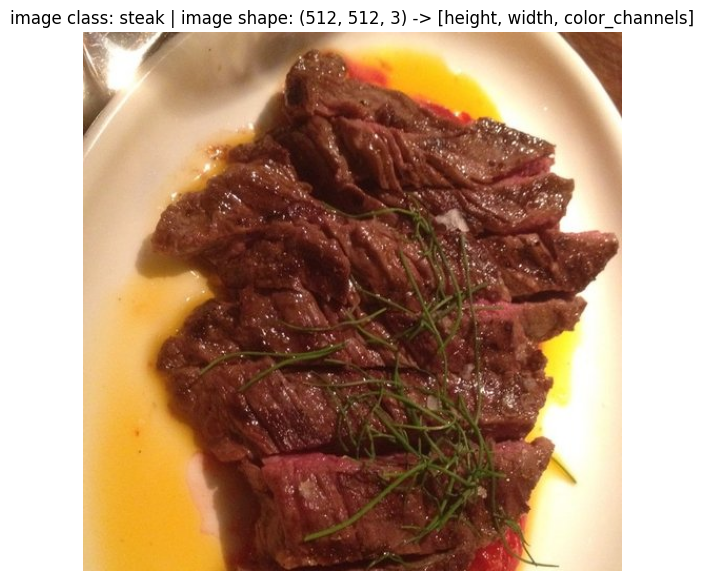

In [44]:
# doing it with matplot lib

import numpy as np
import matplotlib.pyplot as plt

# turn image into array
image_as_array = np.asarray(img)

# plot image with matplotlib

plt.figure(figsize=(10, 7))
plt.imshow(image_as_array)
plt.title(f"image class: {image_class} | image shape: {image_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

## 3. transforming data

1. turn data into tensors
2. turn it into `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`


In [45]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 transforming data with `torchvision.transforms`

In [46]:
# write a transform for image
data_transform = transforms.Compose([

    # resize images to 64x64
    transforms.Resize(size = (64, 64)),

    # flip the images randomly horizontaly
    transforms.RandomHorizontalFlip(p = 0.5),

    # turn the image into a torch tensor
    transforms.ToTensor()
])

In [47]:
data_transform(img).shape

torch.Size([3, 64, 64])

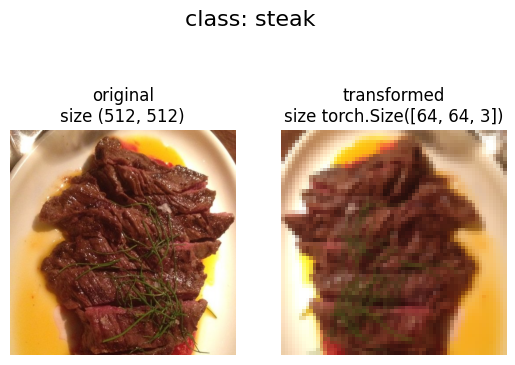

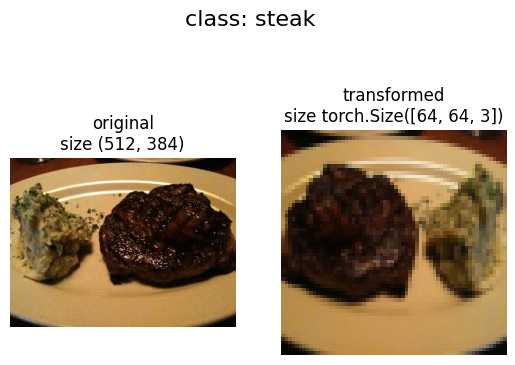

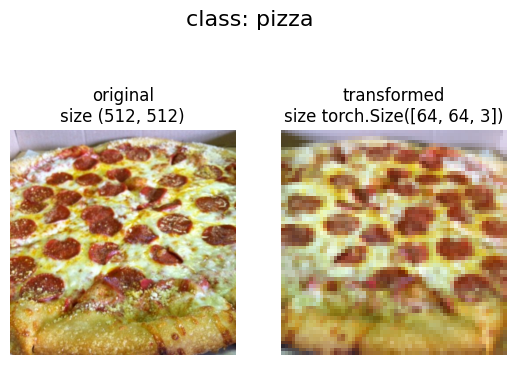

In [48]:
def plot_tranformed_images(image_paths, transform, n = 3, seed = 42):
  """
    selects random images from a path of images and loads/tranforms
    them then plots the original and the transformed version.
  """

  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f'original\nsize {f.size}')
      ax[0].axis(False)

      # transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note that we permuted the image channels: (C, H, W) -> (H, W, C)

      ax[1].imshow(transformed_image)
      ax[1].set_title(f'transformed\nsize {transformed_image.shape}')
      ax[1].axis(False)

      fig.suptitle(f'class: {image_path.parent.stem}', fontsize = 16)

plot_tranformed_images(image_paths=image_path_list,
                       transform=data_transform,
                       n=3,
                       seed=42)

### 4. Option 1: loading image data using `ImageFolder`

we can load image classification data using `torchvision.datasets.ImageFolder`

In [49]:
# use ImageFolder to create dataset(s)

from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform, # a transform fot the data
                                  target_transform = None, # transform for the label/target
                                  )

test_data = datasets.ImageFolder(root = test_dir,
                            transform = data_transform, # a transform fot the data
                            target_transform = None, # transform for the label/target
                            )

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [50]:
# get class names as a list

class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [51]:
# get class names as a dict

class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [52]:
# check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [53]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [60]:
img, label = train_data[0][0], train_data[0][1]
print(f'image tensor:\n {img}')
print(f'image shape: {img.shape}')
print(f'image datatype: {img.dtype}')
print(f'image label: {label}')
print(f'label datatype: {type(label)}')

image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

original shape: torch.Size([3, 64, 64]) -> [color_cahnnels, height, width]
image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

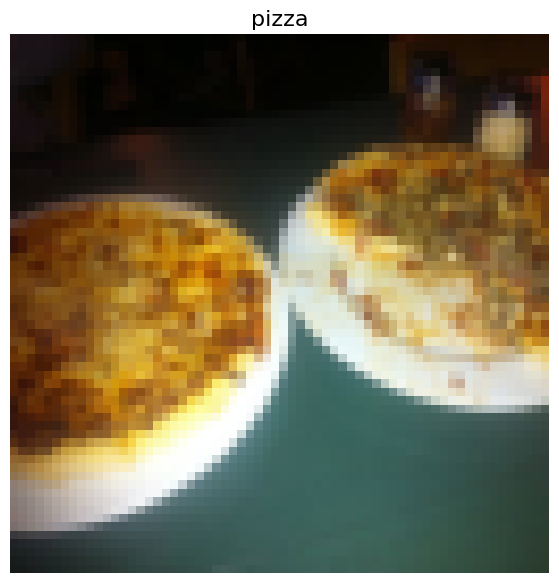

In [61]:
# rearrange the other of dimensions
img_permute = img.permute(1, 2, 0)

# print out different shapes
print(f'original shape: {img.shape} -> [color_cahnnels, height, width]')
print(f'image permute: {img_permute.shape} -> [height, width, color_channels]')

# plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize = 16)

## 4.1 turn loaded images into `DataLoader`

a `DataLoader` is going to help us turn our `Dataset` into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time

In [67]:
# turn train and test datasets into DataLoader s
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = os.cpu_count(),
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = os.cpu_count(),
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79906c8576a0>,
 <torch.utils.data.dataloader.DataLoader at 0x79906c855ba0>)

In [68]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [69]:
img, label = next(iter(train_dataloader))

#  batch size will now be 1
print(f'image shape: {img.shape} -> [batch_size, color_channels, height, width]')
print(f'image shape: {label.shape}')

image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
image shape: torch.Size([1])


## 5. option 2: loading image data with a custom `Dataset`

1. want to be able to load images from file
2. want to be able to get class names from the Dataset
3. want to be able to get classes as a dict from the dict

pros:
* you can create a `Dataset` out of almost anything
* not limited to pytorch pre-built `Dataset` functions

cons:
* even though you could create `Dataset` out of almost anything, it doesn't mean it will work
* using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

All custom datasets in pytorch subclass the `torch.utils.data.Dataset` class

In [70]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [71]:
# Instance of torchvision.datasets.ImageFolder()

train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 creating a helper function to get class names

we want a function to:
1. get the class names using `os.scandir()` to traverse a target directory (ideally the dir is in standard image classification format).
2. raise an error if the class names aren't found (if this happens, there might be something wrong with the dir structure).
3. turn the class names into a dict and a list and return them


In [73]:
# setup path for target directory

target_directory = train_dir
print(f'target dir: {target_directory}')

# get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [75]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:

  """
    Find the class folder names in a target directory.
  """

  # 1. get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}, please chack file structure.")

  # 3. create a dictionary of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [76]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})